# Beam Search with CayleyPy

This notebook shows how to use CayleyPy to find path from random permutation to identity permutation in LRX Cayley graph.

In other words, it decomkposes arbitrary permutation into composition of just three permutations (shift left, shift right and swap two elements) in some order.

The approach is:
* Generate random walks using CayleyGraph.random_walks.
* Train a neural netork on them to predict distance from arbitrary permutation to identity permutation.
* Use CayleyGraph.beam_search using trained neural network as predictor.

In [1]:
!pip install git+https://github.com/cayleypy/cayleypy

  Cloning https://github.com/cayleypy/cayleypy to /tmp/pip-req-build-eqk9y54c
  Running command git clone --filter=blob:none --quiet https://github.com/cayleypy/cayleypy /tmp/pip-req-build-eqk9y54c
  Resolved https://github.com/cayleypy/cayleypy to commit 2f7f13452f1500584fad7e8f62a0f003a5516ba2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cayleypy: filename=cayleypy-0.1.0-py3-none-any.whl size=140391 sha256=cca199b82d05a4ce44e9db865485c3e90370f334edc6036818da4eac65880405
  Stored in directory: /tmp/pip-ephem-wheel-cache-tyeoyh8c/wheels/5d/b5/53/86782f2010b218369465580e31a6c289b7f2a73390b39a23f3
Successfully built cayleypy


In [2]:
from cayleypy import PermutationGroups, CayleyGraph, Predictor, prepare_graph

n=12
graph=CayleyGraph(PermutationGroups.lrx(n))
X, y = graph.random_walks(width=10000, length=n*(n-1)//2, mode="bfs")

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split


# Training parameters.
hidden_dims = [256]
learning_rate = 0.001


class Net(torch.nn.Module):
    def __init__(self, input_size, num_classes, hidden_dims):
        super().__init__()
        self.num_classes=num_classes

        input_size = input_size * self.num_classes
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(torch.nn.Linear(input_size, hidden_dim))
            layers.append(torch.nn.GELU())
            input_size = hidden_dim
            
        layers.append(torch.nn.Linear(input_size, 1))
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = torch.nn.functional.one_hot(x.long(), num_classes=self.num_classes).float().flatten(start_dim=-2)
        return self.layers(x.float()).squeeze(-1)

input_size = graph.definition.state_size
num_classes = int(max(graph.central_state))+1
model = Net(input_size, num_classes, hidden_dims).to(graph.device)

# Prepare training and validation datasets.
val_ratio = 0.1
batch_size = 1024
dataset = TensorDataset(X, y.float())
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch = [0]
def train_one_epoch():
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item() * xb.size(0)

    avg_train_loss = total_train_loss / train_size
    avg_val_loss = total_val_loss / val_size
    print(f"Epoch {epoch[0]} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    epoch[0] +=1

In [4]:
for _ in range(50):
    train_one_epoch()

Epoch 0 | Train Loss: 418.8469 | Val Loss: 228.1224
Epoch 1 | Train Loss: 151.0241 | Val Loss: 95.8491
Epoch 2 | Train Loss: 91.6282 | Val Loss: 90.1976
Epoch 3 | Train Loss: 88.5630 | Val Loss: 88.0693
Epoch 4 | Train Loss: 86.8782 | Val Loss: 86.7898
Epoch 5 | Train Loss: 85.8221 | Val Loss: 85.9725
Epoch 6 | Train Loss: 85.0316 | Val Loss: 85.3506
Epoch 7 | Train Loss: 84.3466 | Val Loss: 84.8043
Epoch 8 | Train Loss: 83.6643 | Val Loss: 84.4429
Epoch 9 | Train Loss: 82.9802 | Val Loss: 83.5826
Epoch 10 | Train Loss: 82.2451 | Val Loss: 82.9229
Epoch 11 | Train Loss: 81.5692 | Val Loss: 82.3900
Epoch 12 | Train Loss: 80.8673 | Val Loss: 81.7405
Epoch 13 | Train Loss: 80.2314 | Val Loss: 81.2727
Epoch 14 | Train Loss: 79.6734 | Val Loss: 80.9361
Epoch 15 | Train Loss: 79.1566 | Val Loss: 80.5722
Epoch 16 | Train Loss: 78.7009 | Val Loss: 80.2263
Epoch 17 | Train Loss: 78.2821 | Val Loss: 79.8792
Epoch 18 | Train Loss: 77.8486 | Val Loss: 79.5656
Epoch 19 | Train Loss: 77.4402 | Val L

### 1. Success rate: neural network vs Hamming

Demonstrate that the probability of finding path using neural network as scorer is much higher than when using a simple heursitic such as Hamming distance (in other words, scoring does make a difference).

In fact, at beam width $10^6$ we always find the path using the neural network.

In [5]:
import numpy as np

start_states = [np.random.permutation(n) for _ in range(100)]

def measure_success(predictor, beam_width):
    success_count = 0
    for start_state in start_states:
        graph.free_memory()
        result = graph.beam_search(start_state=start_state, beam_width=beam_width, max_iterations=n*n, predictor=predictor)
        success_count += result.path_found
    return success_count/len(start_states)

beam_size_range = [1, 10, 10**2, 10**3, 10**4, 10**5, 10**6]
hamming_success_rates = []
nn_success_rates = []
for beam_size in beam_size_range:
    hamming_success_rates.append(measure_success(Predictor(graph, "hamming"), beam_size))
    nn_success_rates.append(measure_success(Predictor(graph, model), beam_size))


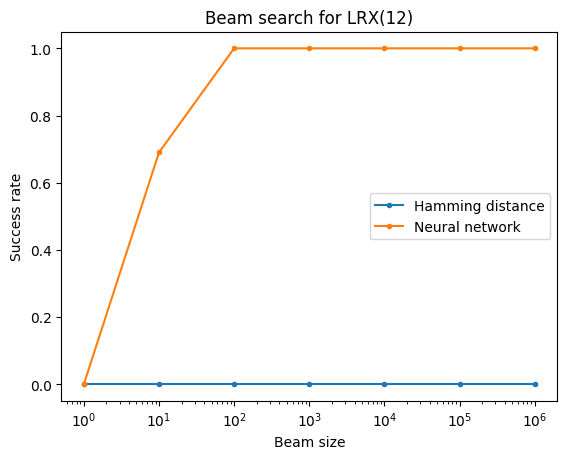

In [6]:
from matplotlib import pyplot as plt

plt.plot(beam_size_range, hamming_success_rates, label="Hamming distance", marker='.')
plt.plot(beam_size_range, nn_success_rates, label="Neural network", marker='.')
plt.xlabel('Beam size')
plt.ylabel('Success rate')
plt.legend()
plt.xscale('log')
plt.title("Beam search for LRX(12)")
plt.show()

### 2. Example of path finding.

In [7]:
start_state = np.random.permutation(n)
print("Start state:", start_state)
result = graph.beam_search(
    start_state=start_state, beam_width=10**6, max_iterations=n*n, predictor=Predictor(graph, model), return_path=True)
print(result)

Start state: [ 7  8  0  1  6  3  5  4  2 10 11  9]
BeamSearchResult(path_length=40, path=R.X.R.X.L.X.L.X.R.X.R.R.X.R.R.X.R.X.R.X.R.X.L.X.L.X.L.X.R.X.L.L.L.L.X.L.X.L.L.L)


### 3. Average path length 

Let's find average length of found path when we start from random permutation.

In [8]:
path_lengths = []
for _ in range(20):
    start_state = np.random.permutation(n)
    result = graph.beam_search(start_state=start_state, beam_width=10**6, max_iterations=n*n, predictor=Predictor(graph, model))
    path_lengths.append(result.path_length)
    
print("Path lengths", path_lengths)
print("Average path length", np.mean(path_lengths))

Path lengths [34, 48, 50, 47, 36, 32, 34, 45, 47, 30, 49, 50, 46, 43, 32, 45, 44, 51, 43, 49]
Average path length 42.75
